In [1]:
import numpy as np
import pandas as pd

import mlgrad.avragg as avragg
import mlgrad.model as model
import mlgrad.loss as loss
import mlgrad.func as func
import mlgrad.func2 as func2

from mlgrad.regr import averaging_function, regression, m_regression_irls, \
                        r_regression_irls, m_regression, \
                        plot_losses_and_errors, plot_yy, exclude_outliers

from mlgrad import erm_fg, erm_sg, erm_irgd, fg, fg_rud, sg, weights, averager_it, erisk, mrisk

from pprint import pprint

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import sys
print(sys.version)

3.11.2 (main, Mar 13 2023, 12:18:29) [GCC 12.2.0]


In [2]:
df = pd.read_csv("data/boston.csv", sep=',')
X = df.values
Y = X[:,-1].copy()
X = X[:,:-1].copy()

print(len(Y))

scaler = StandardScaler()
Xt = scaler.fit_transform(X)


506


In [3]:
def sigma_neuron_layer2(n_input, n_output):
    outfunc = func.Sigmoidal(0.5)
    layer = model.SigmaNeuronModelLayer(outfunc, n_input, n_output)
    return layer

In [4]:
def create_nn(n_input, n_layers):
    body = model.FFNetworkModel()
    n_prev_layer = n_input
    for n_layer in n_layers:
        body.add(model.LinearLayer(n_prev_layer, n_layer))
        body.add(model.ScaleLayer(func.Sigmoidal(1.0), n_layer))
        n_prev_layer = n_layer

    head = model.LinearModel(n_layers[-1])
    ffnn = model.FFNetworkFuncModel(head, body)
    ffnn.allocate()
    return ffnn

In [5]:
loss_func_sq = loss.ErrorLoss(func.Square())
loss_func_sqrt = loss.ErrorLoss(func.Sqrt(1.0))

In [6]:
n_hidden1 = 27
n_hidden2 = 13
n_layers = (n_hidden1, n_hidden2)
n_input = Xt.shape[1]

In [7]:
ffnn1 = create_nn(n_input, n_layers)
ffnn1.init_param()
ffnn2 = create_nn(n_input, n_layers)
ffnn2.init_param()
ffnn3 = create_nn(n_input, n_layers)
ffnn3.init_param()
ffnn4 = create_nn(n_input, n_layers)
ffnn4.init_param()
ffnn5 = create_nn(n_input, n_layers)
ffnn5.init_param()

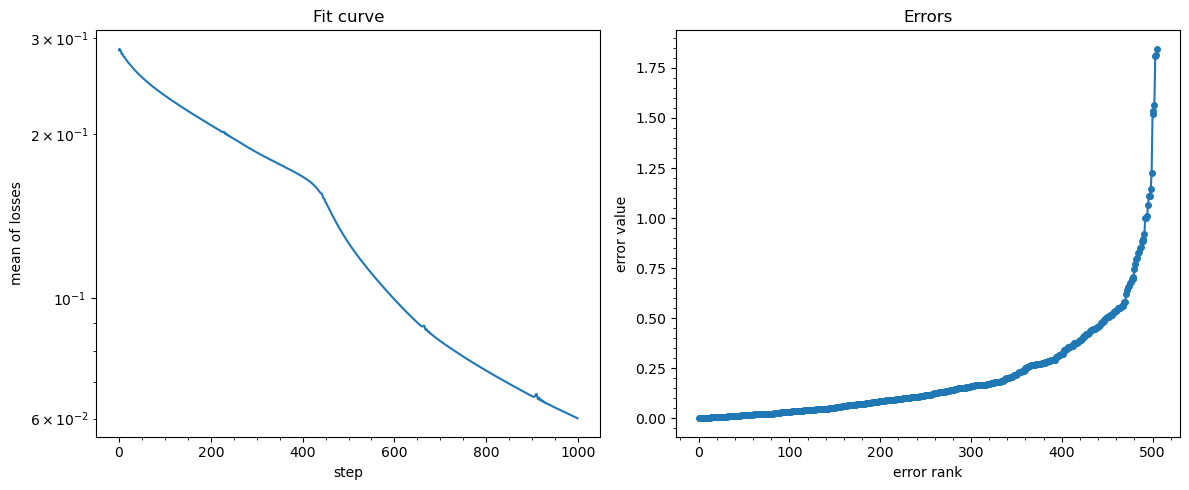

In [8]:
fg_bp = regression(Xt, Y, ffnn1, h=0.001, tol=1.0e-8, n_restart=5)
plot_losses_and_errors(fg_bp, Xt, Y)

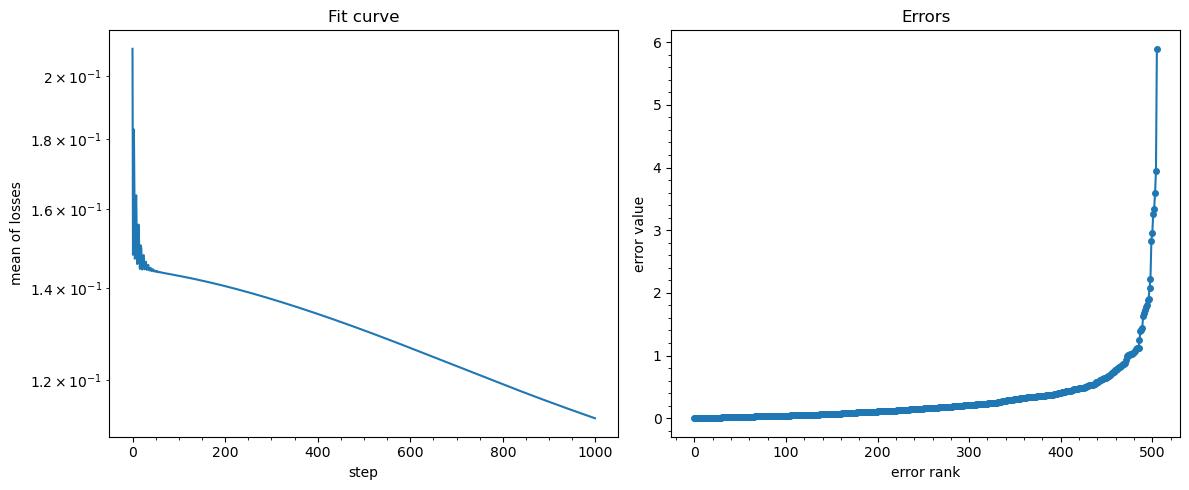

In [9]:
fg_sqrt = regression(Xt, Y, ffnn2, loss_func=loss_func_sqrt, h=0.001, tol=1.0e-8, n_restart=5)
plot_losses_and_errors(fg_sqrt, Xt, Y)

0.006325581276152438


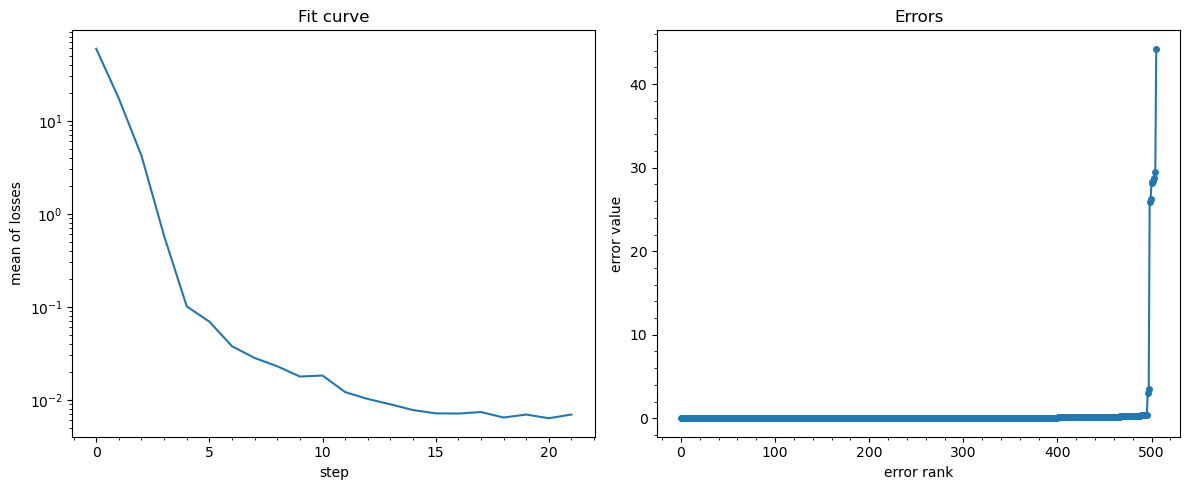

In [10]:
avg_wm = averaging_function("WM", rhofunc=func.Quantile_Sqrt(0.98, 0.001))
irgd_wm = m_regression_irls(Xt, Y, ffnn3, agg_func=avg_wm, h=0.001, tol=1.0e-8)
plot_losses_and_errors(irgd_wm, Xt, Y)

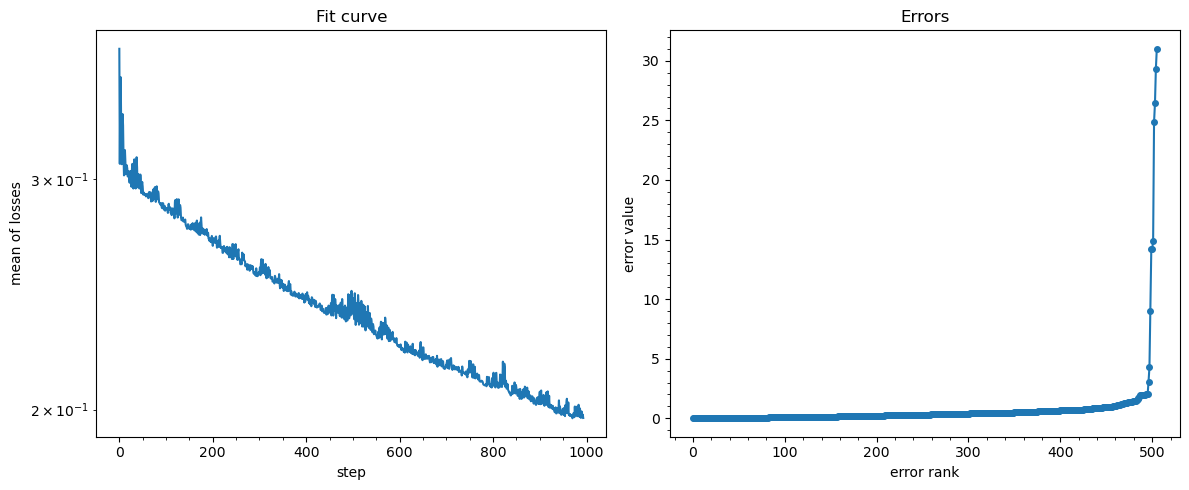

In [11]:
avg_22 = averaging_function("WM", rhofunc=func.Quantile_Sqrt(0.98, 0.001))
alg_fg2 = m_regression(Xt, Y, ffnn4, agg_func=avg_22, h=0.001, tol=1.0e-8, n_restart=5)
plot_losses_and_errors(alg_fg2, Xt, Y)

(506, 13) float64 (496, 13) float64


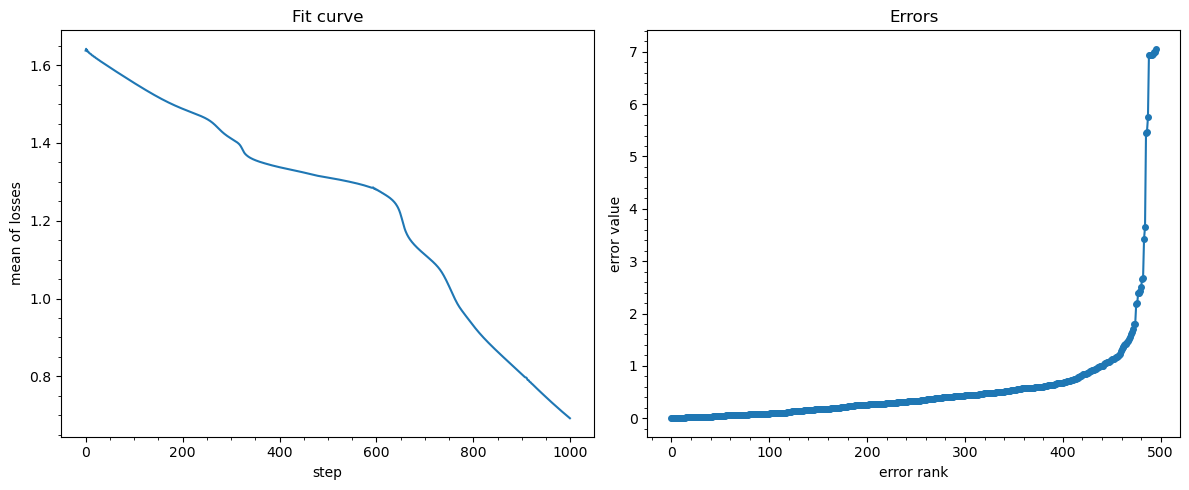

In [12]:
X_wo, Y_wo = exclude_outliers(ffnn3, Xt, Y, 10)
print(Xt.shape, Xt.dtype, X_wo.shape, X_wo.dtype)
alg2 = regression(X_wo, Y_wo, ffnn5, h=0.001, tol=1.0e-8, n_restart=5)
plot_losses_and_errors(alg2, X_wo, Y_wo, logscale=False)

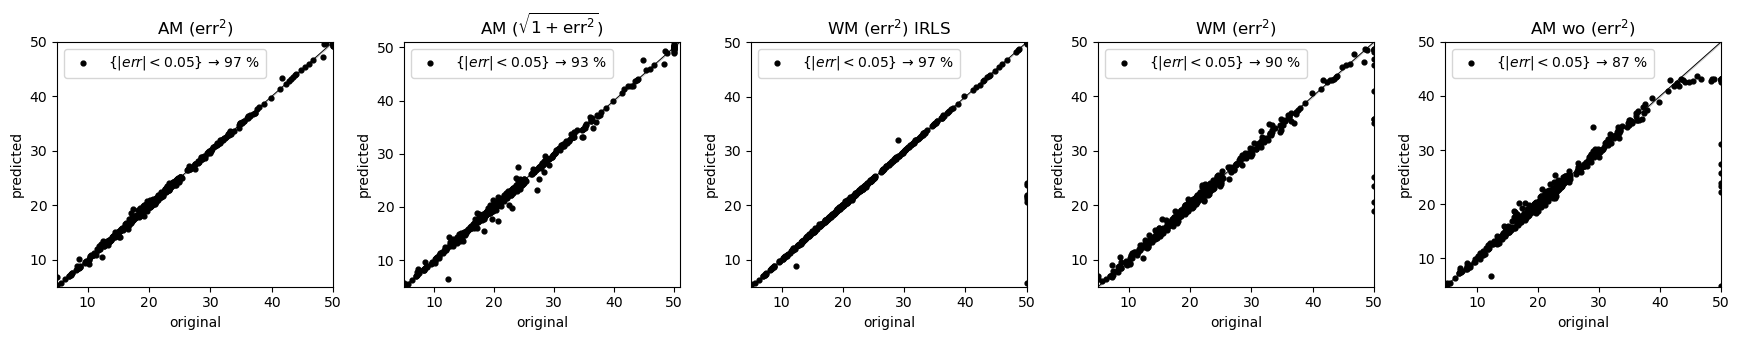

In [13]:
b=0.05
plt.figure(figsize=(5*3.5, 3.5))
plt.subplot(1,5,1)
plot_yy(Xt, Y, ffnn1, r'AM ($\mathrm{err}^2$)', b)
plt.subplot(1,5,2)
plot_yy(Xt, Y, ffnn2, r'AM ($\sqrt{1+\mathrm{err}^2}$)', b)
plt.subplot(1,5,3)
plot_yy(Xt, Y, ffnn3, r'WM ($\mathrm{err}^2$) IRLS', b)
plt.subplot(1,5,4)
plot_yy(Xt, Y, ffnn4, r'WM ($\mathrm{err}^2$)', b)
plt.subplot(1,5,5)
plot_yy(Xt, Y, ffnn5, r'AM wo ($\mathrm{err}^2$)', b)
plt.tight_layout()
plt.show()